# Full vs. Sequential Updates in Bayesian Regression

## 0. Input

In [1]:
# Synthetic data
seed = 1
n_datapoints = 100
true_slope = 2.5
true_intercept = 0.5
noise_scale = 2.0

# Sequential updating
n_chunks = 10

# Priors
slope_mu = 0
slope_sigma = 10
intercept_mu = 0
intercept_sigma = 10
error_sigma = 1

## I. Prerequisites

In [2]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from scipy.optimize import minimize

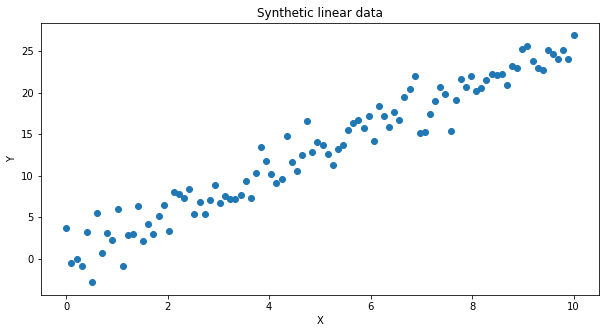

In [3]:
# Generate synthetic data
np.random.seed(seed)
X = np.linspace(0, 10, n_datapoints )[:, None]
noise = np.random.normal(scale=noise_scale, size=X.shape[0])
Y = true_slope * X.squeeze() + true_intercept + noise

# Plot synthetic data
plt.figure(figsize=(10, 5))
plt.scatter(X, Y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Synthetic linear data')
plt.show()

## II. MLE

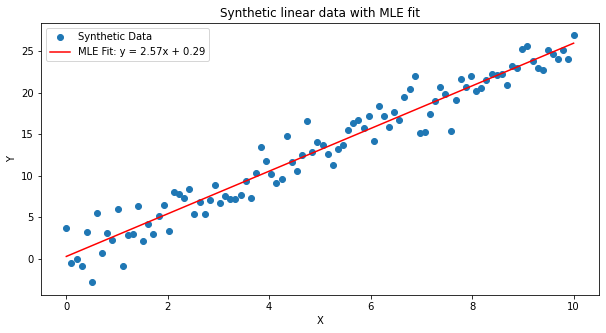

In [4]:
# Define negative log-likelihood fct
def nll(params, X, Y):
    slope, intercept = params
    predictions = slope * X.squeeze() + intercept
    residuals = Y - predictions
    sigma = residuals.std()
    nll = 0.5 * np.sum(np.log(2 * np.pi * sigma ** 2) + residuals**2 / sigma**2)
    return nll

# Initial guess
initial_guess = [1.0, 1.0]

# Minimize negative log-likelihood
result = minimize(nll, initial_guess, args=(X, Y))

# Extract MLE estimates for slope and intercept
slope_mle, intercept_mle = result.x

# Plot synthetic data and fitted line
plt.figure(figsize=(10, 5))
plt.scatter(X, Y, label='Synthetic Data')
plt.plot(X, slope_mle * X + intercept_mle, color='red', label=f'MLE Fit: y = {slope_mle:.2f}x + {intercept_mle:.2f}')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Synthetic linear data with MLE fit')
plt.legend()
plt.show()

## III. Batch Learning

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.


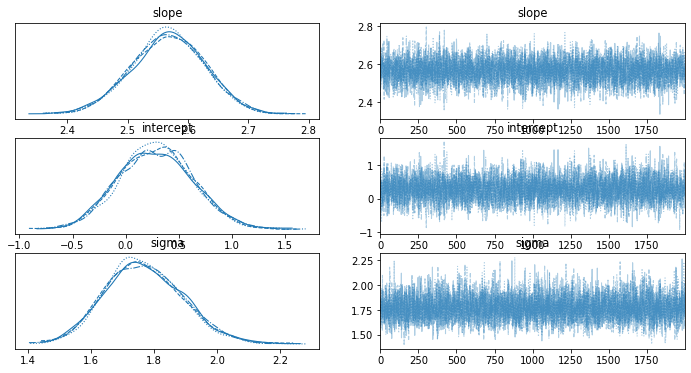

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,2.57,0.06,2.45,2.68,0.00,0.0,4431.95,4619.87,1.0
intercept,0.29,0.35,-0.36,0.93,0.01,0.0,4478.93,4298.59,1.0
sigma,1.77,0.12,1.54,2.00,0.00,0.0,4958.56,4111.77,1.0


In [5]:
with pm.Model() as linear_model:
    # Priors
    slope = pm.Normal("slope", mu=slope_mu, sigma=slope_sigma)
    intercept = pm.Normal("intercept", mu=intercept_mu, sigma=intercept_sigma)
    sigma = pm.HalfNormal("sigma", sigma=error_sigma)

    # Expected value of outcome
    mu = intercept + slope * X.squeeze()

    # Likelihood
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

    # Sample from the posterior
    trace_batch = pm.sample(2000, return_inferencedata=True, progressbar=True)

# Plot posterior distributions
az.plot_trace(trace_batch)
plt.show()

# Show summary
display(az.summary(trace_batch, round_to=2))

## IV. Sequential Learning

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 30 seconds.


Chunk 1 summary:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,1.72,2.37,-2.58,6.37,0.04,0.03,3287.98,3536.39,1.0
intercept,0.65,1.29,-1.83,3.09,0.02,0.02,3112.27,3161.16,1.0
sigma,2.23,0.39,1.55,2.98,0.01,0.00,3460.97,2684.97,1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.


Chunk 2 summary:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,2.19,0.87,0.56,3.84,0.02,0.01,3327.84,3711.00,1.0
intercept,0.62,1.16,-1.61,2.73,0.02,0.02,3189.53,3311.14,1.0
sigma,2.26,0.53,1.42,3.30,0.01,0.01,3491.91,2926.28,1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 31 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7044, but should be close to 0.8. Try to increase the number of tuning steps.


Chunk 3 summary:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,2.37,0.43,1.60,3.20,0.01,0.01,2797.98,3970.48,1.0
intercept,0.92,0.98,-0.96,2.72,0.02,0.01,2812.28,3649.30,1.0
sigma,1.81,0.45,1.10,2.68,0.01,0.01,3268.10,2405.60,1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.


Chunk 4 summary:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,2.39,0.27,1.92,2.91,0.00,0.00,3461.63,3394.17,1.0
intercept,0.62,0.85,-0.99,2.22,0.01,0.01,3487.14,3184.66,1.0
sigma,1.85,0.44,1.16,2.67,0.01,0.01,3926.73,3736.66,1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.


Chunk 5 summary:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,2.51,0.18,2.17,2.84,0.00,0.00,4031.42,4766.03,1.0
intercept,0.81,0.72,-0.52,2.15,0.01,0.01,4071.32,4290.46,1.0
sigma,2.09,0.48,1.27,2.96,0.01,0.01,4453.85,4398.61,1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.


Chunk 6 summary:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,2.53,0.12,2.31,2.75,0.00,0.00,3396.06,4092.84,1.0
intercept,0.71,0.59,-0.45,1.79,0.01,0.01,3416.48,3983.22,1.0
sigma,1.49,0.39,0.89,2.22,0.01,0.00,3774.73,3804.09,1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 33 seconds.


Chunk 7 summary:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,2.57,0.09,2.39,2.73,0.00,0.0,5512.18,5146.75,1.0
intercept,0.83,0.51,-0.12,1.79,0.01,0.0,5380.15,5604.30,1.0
sigma,2.17,0.45,1.40,3.01,0.01,0.0,7141.87,5353.34,1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.


Chunk 8 summary:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,2.51,0.07,2.38,2.64,0.00,0.0,5775.33,5993.47,1.0
intercept,0.59,0.44,-0.25,1.41,0.01,0.0,5462.39,5922.09,1.0
sigma,2.10,0.50,1.24,3.00,0.01,0.0,6059.83,5151.88,1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 33 seconds.


Chunk 9 summary:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,2.52,0.05,2.43,2.61,0.00,0.0,3425.68,4491.60,1.0
intercept,0.59,0.37,-0.08,1.29,0.01,0.0,3455.80,4636.75,1.0
sigma,1.06,0.28,0.62,1.57,0.00,0.0,4474.00,4290.38,1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [slope, intercept, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.


Chunk 10 summary:


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
slope,2.51,0.04,2.45,2.58,0.00,0.0,3890.20,5129.41,1.0
intercept,0.55,0.31,-0.06,1.12,0.01,0.0,3685.62,4856.42,1.0
sigma,1.22,0.27,0.75,1.71,0.00,0.0,6654.99,5465.37,1.0


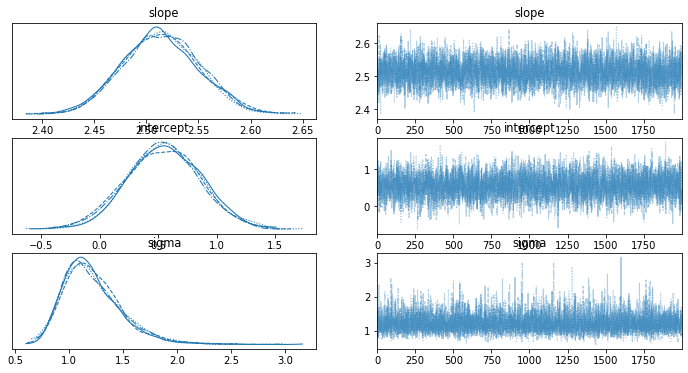

In [6]:
# Function to split data into chunks
def chunk_data(X, Y, chunks):
    chunk_size = len(X) // chunks
    for i in range(0, len(X), chunk_size):
        yield X[i:i + chunk_size], Y[i:i + chunk_size]
        
# Split data into chunks
data_chunks = list(chunk_data(X, Y, n_chunks))

# Initial priors
slope_prior = {'mu': slope_mu, 'sigma': slope_sigma}
intercept_prior = {'mu': intercept_mu, 'sigma': intercept_sigma}
sigma_prior = {'sigma': error_sigma}

summaries = []
for i, (X_chunk, Y_chunk) in enumerate(data_chunks, start=1):
    with pm.Model() as linear_model:
        # Use posterior from the previous iteration as the new prior
        slope = pm.Normal("slope", mu=slope_prior['mu'], sigma=slope_prior['sigma'])
        intercept = pm.Normal("intercept", mu=intercept_prior['mu'], sigma=intercept_prior['sigma'])
        sigma = pm.HalfNormal("sigma", sigma=sigma_prior['sigma'])
        
        # Expected value of outcome
        mu = intercept + slope * X_chunk.squeeze()
        
        # Likelihood of observations
        Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y_chunk)
        
        # Sample from the posterior
        trace_seq = pm.sample(2000, return_inferencedata=True, progressbar=True)
        
        # Update priors for next iteration
        slope_prior['mu'] = np.mean(trace_seq.posterior["slope"].values)
        slope_prior['sigma'] = np.std(trace_seq.posterior["slope"].values, ddof=1)
        intercept_prior['mu'] = np.mean(trace_seq.posterior["intercept"].values)
        intercept_prior['sigma'] = np.std(trace_seq.posterior["intercept"].values, ddof=1)
        sigma_prior['sigma'] = np.mean(trace_seq.posterior["sigma"].values)
        
        # Get summary statistics for current trace
        summary = az.summary(trace_seq, hdi_prob=0.95)
        summaries.append({
            'step': i + 1,
            'mean': summary.loc['slope']['mean'],
            'hpd_2.5': summary.loc['slope']['hdi_2.5%'],
            'hpd_97.5': summary.loc['slope']['hdi_97.5%'],
        })
        
    print(f"Chunk {i} summary:")
    display(az.summary(trace_seq, round_to=2))

df_summaries = pd.DataFrame(summaries)
    
# Plot posterior distributions
az.plot_trace(trace_seq)
plt.show()

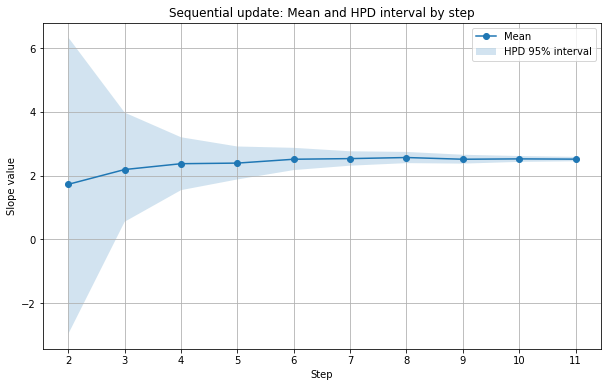

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(df_summaries['step'], df_summaries['mean'], '-o', label='Mean')
plt.fill_between(df_summaries['step'], df_summaries['hpd_2.5'], df_summaries['hpd_97.5'], alpha=0.2, label='HPD 95% interval')
plt.xlabel('Step')
plt.ylabel('Slope value')
plt.title('Sequential update: Mean and HPD interval by step')
plt.xticks(df_summaries['step'])
plt.legend()
plt.grid(True)
plt.show()

## V. Comparison

In [8]:
traces = [trace_batch, trace_seq]

# Initialize empty dict to store mean coefficients
mean_coefficients = {}

# Extract mean of coefficients from each trace
for i, trace in enumerate(traces, start=1):
    trace_summary = az.summary(trace, var_names=["slope", "intercept"])
    mean_coefficients[f'Trace {i}'] = {
        'slope': trace_summary.loc['slope', 'mean'],
        'intercept': trace_summary.loc['intercept', 'mean']
    }

# Convert dict to df for display
df_means = pd.DataFrame(mean_coefficients).T  # Transpose to have traces as rows

# Add True and MLE; rename; reorder
df_means.loc['True'] = [2.5, 0.5]
df_means.loc['MLE'] = [slope_mle, intercept_mle]
df_means.rename(index={'Trace 1': 'Batch'}, inplace=True)
df_means.rename(index={'Trace 2': 'Sequential'}, inplace=True)
df_means = df_means.reindex(['True', 'MLE', 'Batch', 'Sequential'])

display(df_means)

,slope,intercept
True,2.500000,0.500000
MLE,2.566169,0.290321
Batch,2.567000,0.286000
Sequential,2.514000,0.548000
